# <center>Big Data &ndash; Exercises </center>
## <center>Fall 2021 &ndash; Week 8 &ndash; ETH Zurich</center>
## <center>YARN + Spark</center>

**WHEN OPENING THIS NOTEBOOK SELECT NO KERNEL IF THE INTENDED ONE IS NOT FOUND (PYSPARK3)**
Reading: 
- Zaharia, M. et al. (2012). Resilient Distributed Datasets: A Fault-Tolerant Abstraction for In-Memory Cluster Computing. In NSDI. 
- Armbrust, M., et al. (2015). Spark SQL: Relational Data Processing in Spark. In SIGMOD. 

This exercise will consist of 2 main parts: 
* YARN architecture and theory 
* Hands-on practice with Spark on docker

# Exercise 1 &mdash; What is YARN?

Fundamentally, “**Y**et **A**nother **R**esource **N**egotiator”. **YARN**  is a resource scheduler designed to work on existing and new Hadoop clusters. 

YARN supports pluggable schedulers. The task of the scheduler is to share the resources of a large cluster among different tenants (applications) while trying to meet application demands (memory, CPU). A user may have several applications active at a time. 

### 1.1 &ndash; List at least 3 main shortcomings of MapReduce v1, which are addressed by YARN design.

### 1.2 &ndash; State which of the following statements are true:

1. The ResourceManager has to provide fault tolerance for resources across the cluster 
F. application master
1. Container allocation/deallocation can take place in a dynamic fashion as the application progresses. 
T.
1. YARN plans to allow applications to only request resources in terms of memory usage and number of CPUs.
F. disk and network also
1. Communications between the ResourceManager and NodeManagers are heartbeat-based. 
T.
1. The ResourceManager does not have a global view of all usage of cluster resources. Therefore, it tries to make better scheduling decisions based on probabilistic prediction. 
F. deterministic
1. ResourceManager has the ability to request resources back from a running application.
T.

### 1.3 &ndash; Whose responsibility is it? Say which component of YARN is resposible for each of the following tasks.

1. Fault Tolerance of running applications *[ResourceManager | ApplicationMaster | NodeManager ]* 
ApplicationMaster
1. Asking for resources needed for an application *[ResourceManager | ApplicationMaster | NodeManager ]* 
ApplicationMaster
1. Providing leases to use containers *[ResourceManager | ApplicationMaster | NodeManager]*
ResourceManager
1. Tracking status and progress of running applications *[ResourceManager | ApplicationMaster | NodeManager]*
ApplicationMaster

NodeManager: 

### 1.4 &ndash; What is the typical configuration for YARN? Choose for the following components how many instances of them there are in a cluster.

```
1. ResourceManager  a                a. One per cluster

2. ApplicationMaster  c              b. One per node

3. NodeManager     b                 c. Many per cluster, but usually not per every node

4. Container     d                   d. Many per node 
```

## 2. Setup the Spark cluster on Docker

1. Start docker <br> 
   docker-compose up -d

2. Access jupyter notebook <br> 
   http://localhost:8888/lab/tree/work/Exercise08_Spark.ipynb

3. Download datasets
- fruits      :<br> 
  ```wget "https://cloud.inf.ethz.ch/s/YgDaSGbPktFyQMr/download/fruits.txt"```
- yellowthings:<br> 
  ```wget "https://cloud.inf.ethz.ch/s/Fw3R9k9AS9KjYyz/download/yellowthings.txt"```

4. copy the data to hdfs :<br> 
  ```docker cp fruits.txt jupyter:/home/jovyan/work``` <br>
  ```docker cp yellowthings.txt jupyter:/home/jovyan/work``` <br>
(Copying the data to hdfs needs to be done only once and it might take 1-2 minutes.)

## 3. Apache Spark Architecuture

Spark is a cluster computing platform designed to be fast and general purpose. Spark extends the MapReduce model to efficiently cover a wide range of workloads that previously required separate distributed systems, including interactive queries and stream processing. Spark offers the ability to run computations in memory.

At a high level, every Spark application consists of a **driver program** that launches various parallel operations on a cluster. The driver program contains your application's main function and defines distributed datasets on the cluster, then applies operations to them.

Driver programs access Spark through a **SparkContext** object, which represents a connection to a computing cluster. There is no need to create a SparkContext; it is created for you automatically when you run the first code cell in the Jupyter

The driver communicates with a potentially large number of distributed workers called **executors**. The driver runs in its own process and each executor is a separate process. A driver and its executors are together termed a Spark application.

![Image of Account](http://spark.apache.org/docs/latest/img/cluster-overview.png)

### 3.1 Understand resilient distributed datasets (RDD)

An RDD in Spark is simply an immutable distributed collection of objects. Each RDD is split into multiple partitions, which may be computed on different nodes of the cluster. 

##### What are RDD operations?
RDDs offer two types of operations: **transformations** and **actions**.

* **Transformations** create a new dataset from an existing one. Transformations are lazy, meaning that no transformation is executed until you execute an action.
* **Actions** compute a result based on an RDD, and either return it to the driver program or save it to an external storage system (e.g., HDFS)

Transformations and actions are different because of the way Spark computes RDDs. Although you can define new RDDs any time, Spark computes them only in a **lazy** fashion, that is, the first time they are used in an action.

##### Create Spark session (Spark install within jupyter docker image) and context

RDDs can be created from stable storage or by transforming other RDDs. Run the cells below to create RDDs from the sample data files that have been copied to hdfs. 

In [1]:
import json
from pyspark.sql import SparkSession
from pyspark import SparkConf

spark = SparkSession.builder.master('local').getOrCreate()
sc = spark.sparkContext

##### How do I make an RDD?

RDDs can be created from stable storage or by transforming other RDDs. Run the cells below to create RDDs from the sample data files that have been copied to hdfs. 

In [3]:
# sc is the Spark Context object automatically created for you
fruits = sc.textFile('fruits.txt')
yellowThings = sc.textFile('yellowthings.txt')

##### RDD transformations
Following are examples of some of the common transformations available. For a detailed list, see [RDD Transformations](https://spark.apache.org/docs/2.0.0/programming-guide.html#transformations)

Run some transformations below to understand this better. **Note that in the cells below, we're using the `collect()` method. This is in fact an *action*, not a *transformation*, however it's being used in these cells as a means of materializing the results.**

In [4]:
# map
fruitsReversed = fruits.map(lambda fruit: fruit[::-1])
fruitsReversed.collect()

['elppa',
 'ananab',
 'nolem yranac',
 'eparg',
 'nomel',
 'egnaro',
 'elppaenip',
 'yrrebwarts']

In [4]:
# filter
shortFruits = fruits.filter(lambda fruit: len(fruit) <= 5)
shortFruits.collect()

In [5]:
# flatMap
characters = fruits.flatMap(lambda fruit: list(fruit))
characters.collect()

['a',
 'p',
 'p',
 'l',
 'e',
 'b',
 'a',
 'n',
 'a',
 'n',
 'a',
 'c',
 'a',
 'n',
 'a',
 'r',
 'y',
 ' ',
 'm',
 'e',
 'l',
 'o',
 'n',
 'g',
 'r',
 'a',
 'p',
 'e',
 'l',
 'e',
 'm',
 'o',
 'n',
 'o',
 'r',
 'a',
 'n',
 'g',
 'e',
 'p',
 'i',
 'n',
 'e',
 'a',
 'p',
 'p',
 'l',
 'e',
 's',
 't',
 'r',
 'a',
 'w',
 'b',
 'e',
 'r',
 'r',
 'y']

In [6]:
# union between fruits and yellowthings datasets
fruitsAndYellowThings = fruits.union(yellowThings)
fruitsAndYellowThings.collect()

['apple',
 'banana',
 'canary melon',
 'grape',
 'lemon',
 'orange',
 'pineapple',
 'strawberry',
 'banana',
 'bee',
 'butter',
 'canary melon',
 'gold',
 'lemon',
 'pineapple',
 'sunflower']

In [7]:
# intersection between fruits and yellowthings datasets
yellowFruits = fruits.intersection(yellowThings)
yellowFruits.collect()

['banana', 'pineapple', 'canary melon', 'lemon']

In [9]:
# distinct elements in the two datasets
distinctFruitsAndYellowThings = fruitsAndYellowThings.distinct()
distinctFruitsAndYellowThings.collect()

['banana',
 'orange',
 'pineapple',
 'butter',
 'gold',
 'sunflower',
 'apple',
 'canary melon',
 'grape',
 'lemon',
 'strawberry',
 'bee']

In [8]:
# groupByKey
yellowThingsByFirstLetter = yellowThings.map(lambda thing: (thing[0], thing)).groupByKey()
for letter, lst in yellowThingsByFirstLetter.collect():
  print("For letter", letter)
  for obj in lst:
      print(" > ", obj)

For letter b
 >  banana
 >  bee
 >  butter
For letter c
 >  canary melon
For letter g
 >  gold
For letter l
 >  lemon
For letter p
 >  pineapple
For letter s
 >  sunflower


In [10]:
# reduceByKey; key is the number of characters of the fruit name (len(fruit))
numFruitsByLength = fruits.map(lambda fruit: (len(fruit), 1)).reduceByKey(lambda x, y: x + y)
numFruitsByLength.collect()

[(5, 3), (6, 2), (12, 1), (9, 1), (10, 1)]

##### RDD actions
Following are examples of some of the common actions available. For a detailed list, see [RDD Actions](https://spark.apache.org/docs/2.0.0/programming-guide.html#actions).

Run some transformations below to understand this better. 

In [11]:
# collect
fruitsArray = fruits.collect()
yellowThingsArray = yellowThings.collect()
print(fruitsArray)
print(yellowThingsArray)

['apple', 'banana', 'canary melon', 'grape', 'lemon', 'orange', 'pineapple', 'strawberry']
['banana', 'bee', 'butter', 'canary melon', 'gold', 'lemon', 'pineapple', 'sunflower']


In [20]:
# count - how many fruits are
numFruits = fruits.count()
numFruits

In [11]:
# take - show the first three fruits
first3Fruits = fruits.take(3)
first3Fruits

['apple', 'banana', 'canary melon']

In [12]:
# reduce - what letters are used
# map is transformation, reduce is action!
letterSet = fruits.map(lambda fruit: set(fruit)).reduce(lambda x, y: x.union(y))
letterSet

{' ',
 'a',
 'b',
 'c',
 'e',
 'g',
 'i',
 'l',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 't',
 'w',
 'y'}

##### Lazy evaluation
Lazy evaluation means that when we call a transformation on an RDD (for instance, calling `map()`), the operation is not immediately performed. Instead, Spark internally records metadata to indicate that this operation has been requested. Rather than thinking of an RDD as containing specific data, it is best to think of each RDD as
consisting of instructions on how to compute the data that we build up through transformations. Loading data into an RDD is lazily evaluated in the same way transformations are. So, when we call `sc.textFile()`, the data is not loaded until it is necessary. As with transformations, the operation (in this case, reading the data) can
occur multiple times.


Finally, as you derive new RDDs from each other using transformations, Spark keeps track of the set of dependencies between different RDDs, called the lineage graph. For instance, the code bellow corresponds to the following graph:

<img src="https://cloud.inf.ethz.ch/s/BiRkaa97xKEZ7NE/download" height="400">

In [13]:
apples = fruits.filter(lambda x: "apple" in x)
lemons = yellowThings.filter(lambda x: "lemon" in x)
applesAndLemons = apples.union(lemons)
print(applesAndLemons.collect())
print(applesAndLemons.toDebugString().decode("utf-8")) # decode used for nice formatting

['apple', 'pineapple', 'lemon']
(2) UnionRDD[34] at union at NativeMethodAccessorImpl.java:0 []
 |  PythonRDD[32] at RDD at PythonRDD.scala:53 []
 |  fruits.txt MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0 []
 |  fruits.txt HadoopRDD[0] at textFile at NativeMethodAccessorImpl.java:0 []
 |  PythonRDD[33] at RDD at PythonRDD.scala:53 []
 |  yellowthings.txt MapPartitionsRDD[3] at textFile at NativeMethodAccessorImpl.java:0 []
 |  yellowthings.txt HadoopRDD[2] at textFile at NativeMethodAccessorImpl.java:0 []


### 3.2 Exercise

1. What does the code below do?
1. Draw the linage graph for the code
1. List actions and transformations used in it
1. When are all computations executed?
1. If we call `result.collect()` again, what will Spark do to perform the action? 

In [14]:
text = sc.textFile('fruits.txt')
words = text.flatMap(lambda x: x.split(" "))
result = words.map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)
result.saveAsTextFile('result.txt')
result.collect()

[('apple', 1),
 ('banana', 1),
 ('canary', 1),
 ('melon', 1),
 ('grape', 1),
 ('lemon', 1),
 ('orange', 1),
 ('pineapple', 1),
 ('strawberry', 1)]

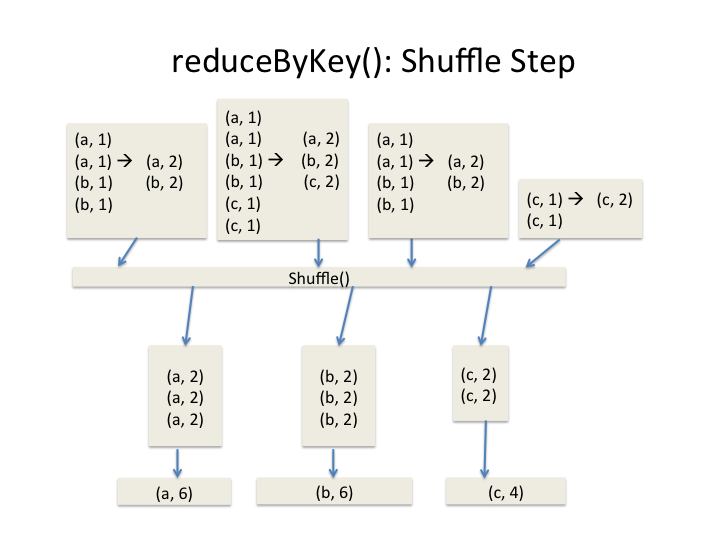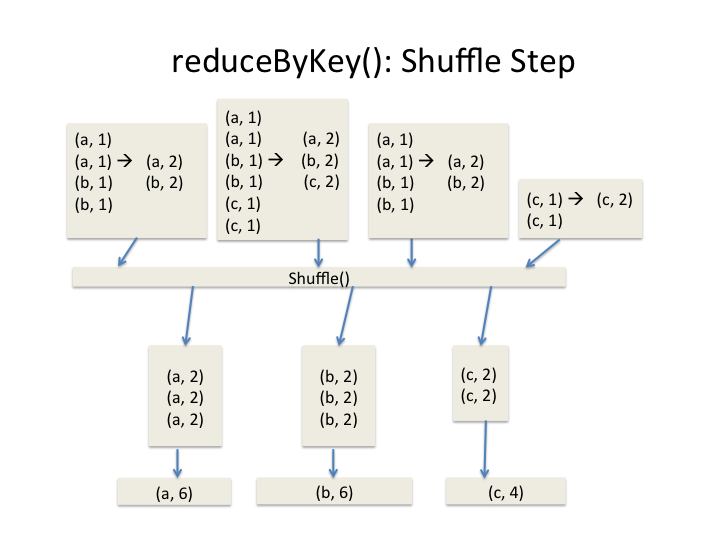

In [15]:
print(result.toDebugString().decode("utf-8")) # reduceByKey has shuffling

(1) PythonRDD[44] at collect at <ipython-input-14-5aa84d0291f8>:5 []
 |  MapPartitionsRDD[40] at mapPartitions at PythonRDD.scala:145 []
 |  ShuffledRDD[39] at partitionBy at NativeMethodAccessorImpl.java:0 []
 +-(1) PairwiseRDD[38] at reduceByKey at <ipython-input-14-5aa84d0291f8>:3 []
    |  PythonRDD[37] at reduceByKey at <ipython-input-14-5aa84d0291f8>:3 []
    |  fruits.txt MapPartitionsRDD[36] at textFile at NativeMethodAccessorImpl.java:0 []
    |  fruits.txt HadoopRDD[35] at textFile at NativeMethodAccessorImpl.java:0 []


### 3.3 Persistence (Caching)

Spark's RDDs are by default recomputed each time you run an action on
them. If you would like to reuse an RDD in multiple actions, you can ask Spark to persist it using `RDD.persist()`. After computing it the first time, Spark will store the RDD contents in memory (partitioned across the machines in your cluster), and reuse them in future actions. Persisting RDDs on disk instead of memory is also possible.

If you attempt to cache too much data to fit in memory, Spark will automatically evict old partitions using a Least Recently Used (LRU) cache policy. For the memory-only storage levels, it will recompute these partitions the next time they are accessed,
while for the memory-and-disk ones, it will write them out to disk. In either case, this means that you don't have to worry about your job breaking if you ask Spark to cache too much data. However, caching unnecessary data can lead to eviction of useful data
and more recomputation time. Finally, RDDs come with a method called `unpersist()` that lets you manually remove them from the cache.

Please note that both `persist()` and `cache()` (which is a simple wrapper that calls `persist(storageLevel=StorageLevel.MEMORY_ONLY)` - see [here](https://spark.apache.org/docs/latest/api/python/_modules/pyspark/rdd.html#RDD.cache) for details -) are lazy operations themselves. The caching operation will, in fact, only take place when the first action is called. With successive action calls, the cached RDD will be used.  

### 3.4 Exercise:
1. Write some code which can benefit from caching.
1. Where should we ask Spark to persist the RDD in Exercise 3.2 to prevent it from re-executing the code when we call `collect()` again?

#### Solution

In [16]:
# Solution 1
fruits.persist()
numFruits = fruits.count()
first3Fruits = fruits.take(3)
# fruits.unpersist()
print(numFruits, first3Fruits)

8 ['apple', 'banana', 'canary melon']


In [17]:
# Solution 2
text = sc.textFile('fruits.txt')
words = text.flatMap(lambda x: x.split(" "))
result = words.map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y).persist() # here!
#result.saveAsTextFile('result.txt')
result.collect()

[('apple', 1),
 ('banana', 1),
 ('canary', 1),
 ('melon', 1),
 ('grape', 1),
 ('lemon', 1),
 ('orange', 1),
 ('pineapple', 1),
 ('strawberry', 1)]

### 3.5 Working with Key/Value Pairs


Spark provides special operations on RDDs containing key/value pairs. These RDDs
are called *pair RDDs*. Pair RDDs are a useful building block in many programs, as
they expose operations that allow you to act on each key in parallel or regroup data
across the network. For example, pair RDDs have a `reduceByKey()` method that can
aggregate data separately for each key, and a `join()` method that can merge two
RDDs together by grouping elements with the same key. Pair RDDs are also still RDDs. 

In [25]:
# Example
rdd = sc.parallelize([("key1", 0) ,("key2", 3),("key1", 8) ,("key3", 3),("key3", 9)])
rdd2 = rdd.mapValues(lambda x: (x, 1)).reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
print(rdd2.collect())
print(rdd2.toDebugString().decode("utf-8"))

[('key1', (8, 2)), ('key2', (3, 1)), ('key3', (12, 2))]
(1) PythonRDD[68] at collect at <ipython-input-25-1373093d76c1>:4 []
 |  MapPartitionsRDD[67] at mapPartitions at PythonRDD.scala:145 []
 |  ShuffledRDD[66] at partitionBy at NativeMethodAccessorImpl.java:0 []
 +-(1) PairwiseRDD[65] at reduceByKey at <ipython-input-25-1373093d76c1>:3 []
    |  PythonRDD[64] at reduceByKey at <ipython-input-25-1373093d76c1>:3 []
    |  ParallelCollectionRDD[63] at readRDDFromFile at PythonRDD.scala:274 []


### 3.6 Exercise
1. What does the code above do? 
sum of value; appearance times of key
2. Where can it be used? Complete the code to perform the desired functionality. 
for average of each value of the key

In [17]:
rdd = sc.parallelize([("key1", 0) ,("key2", 3),("key1", 8) ,("key3", 3),("key3", 9)])
rdd2 = rdd.mapValues(lambda x: (x, 1)).reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
average = rdd2.mapValues(lambda x: x[0] / x[1])
print(average.collect())

### 3.7 Spark Partitioning
Spark programs can choose to control their RDDs' partitioning
to reduce communication. Partitioning will not be helpful in all applications, for
example, if a given RDD is scanned only once, there is no point in partitioning it in
advance. It is useful only when a dataset is reused multiple times in key-oriented
operations such as joins.

Spark's partitioning is available on all RDDs of key/value pairs, and causes the system
to group elements based on a (hash) function of each key. Although Spark does not give
explicit control of which worker node each key goes to (partly because the system is
designed to work even if specific nodes fail), it lets the program ensure that a set of
keys will appear together on some node.


Many of Spark's operations involve shuffling data by key across the network. All of
these will benefit from partitioning. Examples of operations that benefit from
partitioning are `cogroup()`, `groupWith()`, `join()`, `leftOuterJoin()`, `rightOuterJoin()`, `groupByKey()`, `reduceByKey()`, `combineByKey()`, and `lookup()`.

By default PySpark uses hash partitioning as the partitioning function. A way to define a custom partition is by using the function `partitionBy()`. To use `partitionBy()` the RDD must consist of tuple objects. This function is a transformation, therefore a new RDD will be returned. In the following example we are going to see a default partitioning scheme of Spark as well as a custom partitioning.

Partitioning allows some Spark code to run more efficiently, in particular running 'pair' operations on pair RDD (eg. mapValues, reduceByKey) is guaranteed to produce no shuffling in the cluster and also preserve the partitions.

In [19]:
nums = [(1, 1), (2, 2), (3, 3)]

In [20]:
pairs = sc.parallelize(nums)

In [21]:
print("Number of partitions: {}".format(pairs.getNumPartitions()))
print("Partitions structure: {}".format(pairs.glom().collect()))

Number of partitions: 1
Partitions structure: [[(1, 1), (2, 2), (3, 3)]]


Let's try to define a custom partitioning now.

In [22]:
pairs = sc.parallelize(nums).partitionBy(2)

In [24]:
print("Number of partitions: {}".format(pairs.getNumPartitions()))
print("Partitions structure: {}".format(pairs.glom().collect()))

Number of partitions: 2
Partitions structure: [[(2, 2)], [(1, 1), (3, 3)]]


### 3.8 Converting a user program into tasks

A Spark driver is responsible for converting a user program into units of physical execution called tasks. At a high level, all Spark programs follow the same structure: they create RDDs from some input, derive new RDDs from those using transformations, and perform actions to collect or save data. A Spark program implicitly creates a logical **directed acyclic graph (DAG)** of operations.
When the driver runs, it converts this logical graph into a physical execution plan.

Spark performs several optimizations, such as "pipelining" map transformations together to merge them, and converts the execution graph into a set of **stages**.
Each stage, in turn, consists of multiple tasks. The tasks are bundled up and prepared to be sent to the cluster. Tasks are the smallest unit of work in Spark; a typical user program can launch hundreds or thousands of individual tasks.

Each RDD maintains a pointer to one or more parents along with metadata about what
type of relationship they have. For instance, when you call `val b = a.map()` on an
RDD, the RDD `b` keeps a reference to its **parent** `a`. These pointers allow an RDD to be
traced to all of its ancestors.

The following phases occur during Spark execution:
* User code defines a DAG (directed acyclic graph) of RDDs. Operations on RDDs create new RDDs that refer back to their parents, thereby creating a graph.
* Actions force translation of the DAG to an execution plan. When you call an action on an RDD, it must be computed. This requires computing its parent RDDs as well. 
* Spark's scheduler submits a job to compute all needed RDDs. That **job** will have one or more **stages**, which are parallel waves of computation composed of **tasks**. Each **stage** will correspond to **one or more RDDs** in the DAG. A single stage can correspond to multiple RDDs due to pipelining.
* Tasks are scheduled and executed on a cluster
* Stages are processed in order, with individual tasks launching to compute segments of the RDD. Once the final stage is finished in a job, the action is complete.

If you visit the application's web UI (http://localhost:4040/jobs/), you will see how many stages occur in order to
fulfill an action. For more details about the content of this page, see [Spark job debugging](https://docs.microsoft.com/en-us/azure/hdinsight/hdinsight-apache-spark-job-debugging) for Azure Spark.

### 3.9 Exercise. 

1. Why is Spark faster than Hadoop MapReduce?
Spark keeps all the data in RAM. More optimized DAG based operations.
1. Study the examples above via Spark UI. Observe how many stages they have. 
Try reduceByKey, it has two stages because it (may) trigger a shuffle (if identical keys are separated in different partitions)
1. Which of the graphs below are DAGs?

<img src="https://cloud.inf.ethz.ch/s/kkes72cJjsoHkbY/download" height="400">

### 3.10 True or False
Say if the following statements are *true* or *false*, and explain why.

1. Each RDD is split into multiple partitions, which may be computed on different nodes of the cluster.
T
1. Transformations construct a new RDD from a previous one and immediately calculate the result
F
1. Spark's RDDs are by default recomputed each time you run an action on them
T. by default they are
1. After computing an RDD, Spark will store its contents in memory and reuse them in future actions.
F. by default no. you need to persist that
1. When you derive new RDDs using transformations, Spark keeps track of the set of dependencies between different RDDs.
T.

## 4. TF-IDF in Spark (OPTIONAL)
In this exercise you will implement a simple query engine over the Gutenberg dataset using Spark.
The [Gutenberg dataset](https://www.gutenberg.org/) consists of 3036 free ebooks. The goal of this exercise is to develop a search engine to find the most relevant books given a text query.

### 4.1 Get the data
1. You can download the dataset from:<br>
    wget "https://cloud.inf.ethz.ch/s/mNPejXzsTCqKYnd/download/gutenberg.tar.gz"

2. Untar the data

3. Copy the dataset to hdfs:<br>
    docker cp gutenberg jupyter:/home/jovyan/work

### 4.2 Understand TF-IDF

[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a statistic to determine the relative importance of the words in a set of documents. Is is computed as the product of two statistics, term frequency (`tf`) and inverse document frequency (`idf`). 

Given a word `t`, a document `d` (in this case, a book) and the collection of all documents `D` we can define `tf(t, d)` as the number of times `t` appears in `d`. This gives us some information about the content of a document but because some terms (eg. "the") are so common, term frequency will tend to incorrectly emphasize documents which happen to use the word "the" more frequently, without giving enough weight to the more meaningful terms.

The inverse document frequency `idf(t, D)` is a measure of how much information the word provides, that is, whether the term is common or rare across all documents. It can be computed as:

<img src="https://cloud.inf.ethz.ch/s/gw25WWcbd9iXBdK/download" width="300">

where $|D|$ is the total number of documents and the denominator represents how many documents contain the word $t$ at least once. However, this would cause a division-by-zero exception if the user query a word that never appear in the dataset. A better formulation would be:

<img src="https://cloud.inf.ethz.ch/s/fXffB5g59y3y2an/download" width="300">

Then, the `tdidf(t, d, D)` is calculated as follows:

<img src="https://cloud.inf.ethz.ch/s/2dAsg3k2QaL3XMz/download" width="300">

A high weight in `tfidf` is reached by a high term frequency (in the given document) and a low document frequency of the term in the whole collection of documents.

Having already implemented TF-IDF last week in pseudocode, in this week we are going to implement it in Spark. The following code snippet imports the whole dataset into an RDD.

In [68]:
# sc is automatically defined as SparkContext
# docs will be an RDD in the format [(docName, content)]
docs = sc.wholeTextFiles("gutenberg/*.txt", minPartitions=100)

# number of documents in the folder
docs_number = docs.count()

# display the [(docName, content)] values
#docs.collect()

#### TF-IDF solution code